# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *

In [4]:
from fastai.datasets import *

In [5]:
PATH = Path('/home/jupyter/.fastai/data/pascal')

In [9]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [10]:
IMAGES, ANNO, CAT = ['images', 'annotations', 'categories']

In [11]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

In [220]:
cats = {o[ID]:o['name'] for o in trn_j[CAT]}

In [221]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [13]:
trn_fns = {o[ID]: o[FILE_NAME] for o in trn_j[IMAGES]}

In [14]:
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [15]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [16]:
IMG_PATH = PATH/JPEGS

In [17]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

Everything is fine until the above

In [23]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[1]+bb[3], bb[0]+bb[2]])

In [24]:
trn_anno = collections.defaultdict(lambda: [])

In [25]:
for o in trn_j[ANNO]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))

In [17]:
# Doubt - Why are there less elements in trn_anno than trn_j?
#Ans. The annotations contain all boxes, some images may have several boxes
#Each with a category number telling us what the image is

In [18]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 270, 351]), 7)]

In [19]:
im0_a = im_a[0]; im_a

[(array([ 96, 155, 270, 351]), 7)]

In [20]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc); bb_fastai

array([ 96, 155, 270, 351])

In [21]:
def bb_hw(a): return np.array([a[1],a[0],a[3] - a[1],a[2] - a[0]])

In [22]:
bb_back2voc = bb_hw(bb_fastai); bb_back2voc

array([155,  96, 196, 174])

In [23]:
im0_d

{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}

In [24]:
im = open_image(IMG_PATH/trn_fns[12]); type(im)

fastai.vision.image.Image

Experiments below

In [25]:
b = im0_a[0]; b

array([ 96, 155, 270, 351])

In [26]:
from PIL import Image as img

In [27]:
im = img.open(IMG_PATH/im0_d[FILE_NAME])

I managed to draw the bounding box using python imaging library

In [28]:
from PIL import ImageDraw as imdr

In [29]:
draw = imdr.Draw(im)

In [30]:
draw.rectangle((b[1], b[0], b[3], b[2]))

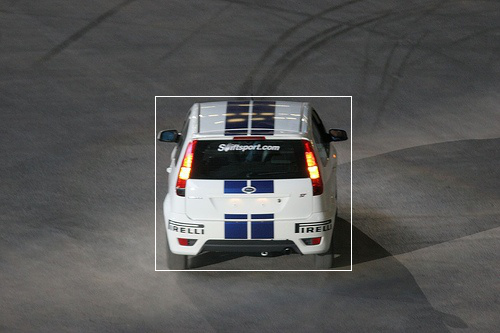

In [31]:
im

Continue from here

Success with finding a function that takes the input as an image, and returns it with the boundary boxes

In [32]:
im0_a[0]

array([ 96, 155, 270, 351])

In [33]:
trn_anno[17]

[(array([ 61, 184, 199, 279]), 15), (array([ 77,  89, 336, 403]), 13)]

In [34]:
trn_anno[12]

[(array([ 96, 155, 270, 351]), 7)]

In [35]:
b = trn_anno[12][0][0]; b
c = cats[trn_anno[12][0][1]]

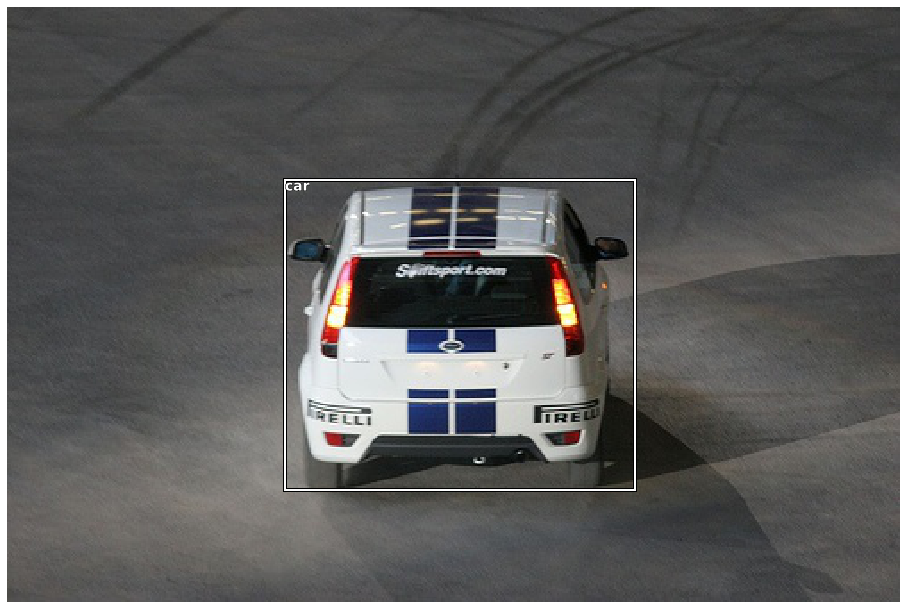

In [36]:
car = open_image(IMG_PATH/trn_fns[12])
bbox = ImageBBox.create(*car.size, [b], labels = [0], classes = ['car'])
car.show(y = bbox, figsize = (16,12))

In [37]:
type(car)

fastai.vision.image.Image

In [38]:
def get_bb_ex():
    img = open_image(IMG_PATH/trn_fns[12])
    return img, ImageBBox.create(*car.size, [b], labels = [0], classes = ['car'])

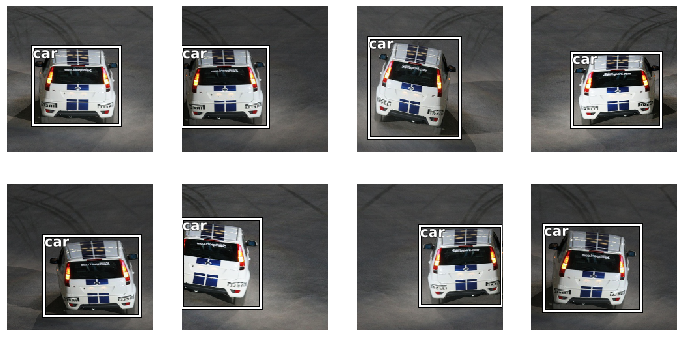

In [39]:
tfms = get_transforms()
_, axs = plt.subplots(2,4, figsize=(12, 6))
for ax in axs.flatten():
    img, bbox = get_bb_ex()
    img = img.apply_tfms(tfms[0], size = 224)
    bbox = bbox.apply_tfms(tfms[0], do_resolve = False, size =224)
    img.show(ax = ax, y = bbox)

In [40]:
horseb1 = trn_anno[17][0][0]; 
horseb2 = trn_anno[17][1][0]

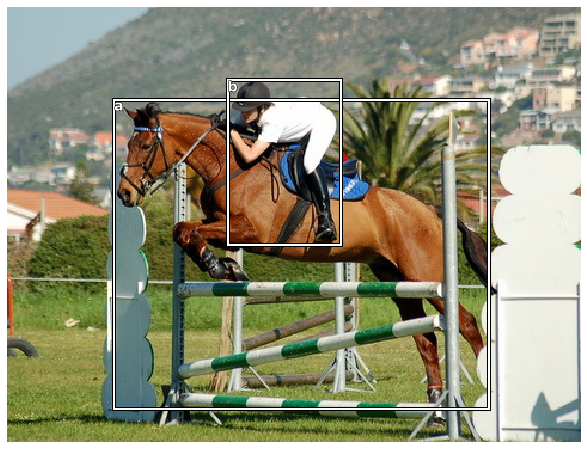

In [41]:
horse = open_image(IMG_PATH/trn_fns[17])
bbox = ImageBBox.create(*horse.size, [horseb2, horseb1], labels = [0,1], classes = ['a', 'b'])
horse.show(y=bbox, figsize = (16, 8))

In [42]:
def draw_idx(i):
    image = open_image(IMG_PATH/trn_fns[i])
    bblist, cnames = [], []
    for b, c in trn_anno[i]:
        bblist.append(b)
        cnames.append(cats[c])
    bbox = ImageBBox.create(*image.size, bblist,list(range(len(cnames))), cnames)
    print(image.shape)
    image.show(y = bbox, figsize = (16,8))

torch.Size([3, 500, 334])


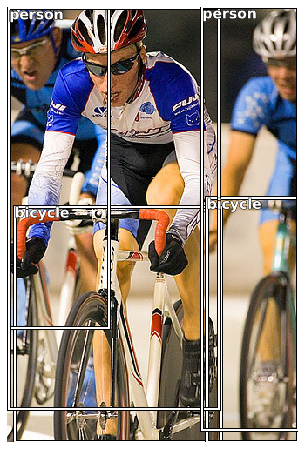

In [43]:
draw_idx(23)

Largest Item classifier

In [44]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key = lambda x: np.product(x[0][-2:] - x[0][:2]), reverse = True)
    return b[0]

Tests below to figure out how the biggest boundary box was calculated

In [45]:
race = open_image(IMG_PATH/trn_fns[23])
bbox = ImageBBox.create(*race.size, [big[4]], labels = [0], classes = ['a'])
race.show(y=bbox, figsize = (16, 8))

NameError: name 'big' is not defined

In [46]:
cats[2], cats[15]

('bicycle', 'person')

In [ ]:
draw_idx(23)

Continue from above

In [47]:
trn_anno[]

[(array([106,   8, 263, 499]), 1),
 (array([199, 420, 226, 482]), 1),
 (array([187, 324, 223, 411]), 1)]

In [48]:
type(trn_anno)

collections.defaultdict

In [49]:
trn_updated_anno = []
for o in trn_anno:
    if o == []:
        continue
    trn_updated_anno
    

In [ ]:
trn_updated_anno

In [26]:
trn_lrg_anno = collections.defaultdict(lambda :[])

In the new definition, I skipped over the part that required me to raise an exception if b was empty, i.e no boundary box

In [27]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key = lambda x: np.product(x[0][-2:] - x[0][:2]), reverse = True)
    return b[0]

In [28]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [53]:
test_anno = trn_lrg_anno

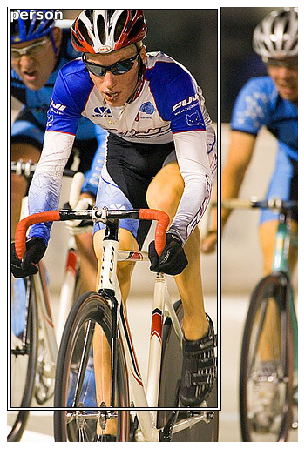

In [54]:
b,c = trn_lrg_anno[23]
race = open_image(IMG_PATH/trn_fns[23])
bbox = ImageBBox.create(*race.size, [b], labels = [0], classes = [cats[c]])
race.show(y=bbox, figsize = (16, 8))

In [55]:
(PATH/'tmp').mkdir(exist_ok = True)
CSV = PATH/'tmp/lrg.csv'

In [56]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                 'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]},
                  columns = ['fn', 'cat'])
df.to_csv(CSV, index = False)

Now using fastai v1 methods

In [57]:
CSV = PATH/'tmp/lrg.csv'

In [58]:
bs = 64

In [59]:
df = pd.read_csv(CSV); df.head()

fn        cat
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

In [60]:
t = df.head()

In [62]:
t.head()

fn  cat
0  000012.jpg    0
1  000017.jpg    0
2  000023.jpg    0
3  000026.jpg    0
4  000032.jpg    0

In [63]:
PATH/JPEGS

PosixPath('/home/jupyter/.fastai/data/pascal/VOCdevkit/VOC2007/JPEGImages')

In [115]:
src = ImageList.from_csv(PATH, 'tmp/lrg.csv', folder = JPEGS)

In [116]:
src = src.split_by_rand_pct(0.2)

In [117]:
src = src.label_from_df()

In [118]:
tfms = get_transforms()
dataclass = (src.transform(tfms, resize_method= ResizeMethod.SQUISH, size = 224)
       .databunch().normalize(imagenet_stats))

In [119]:
x,y = dataclass.valid_ds[0]

Jumping around from below, trying to concat two datasets

In [172]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds1, ds2):
        self.ds1 = ds1
        self.ds2 = ds2
    def __len__(self):
        return len(self.ds1)
    def __getitem__(self, i):
        x,y1 = self.ds1[i]
        _,y2 = self.ds2[i]
        return (x, (y1,y2))

In [173]:
trn_ds = ConcatLblDataset(data.train_ds, dataclass.train_ds)

In [178]:
x, y = trn_ds[10]

In [179]:
y

(ImagePoints (600, 600), Category boat)

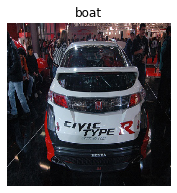

In [180]:
x.show(y = y[1])

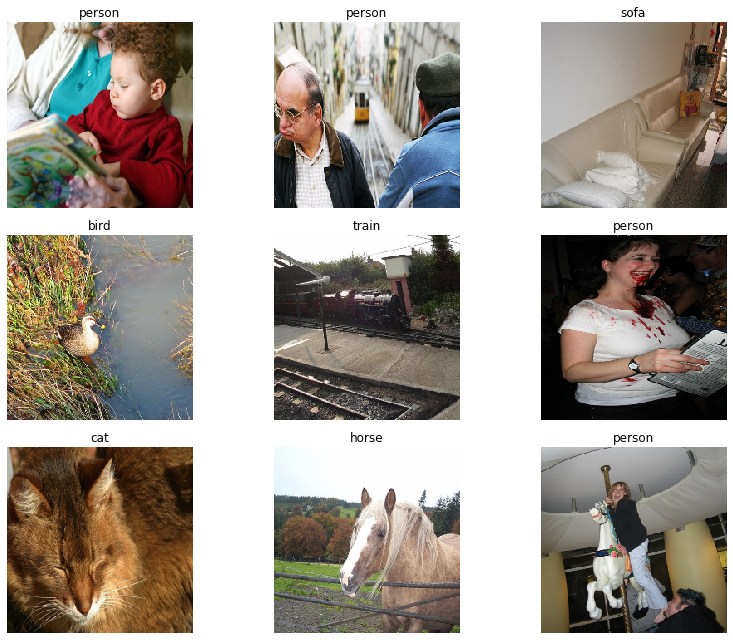

In [70]:
data.show_batch(rows = 3, figsize = (12, 9))

In [10]:
arch = models.resnet34

In [12]:
from fastai.metrics import accuracy_thresh

In [11]:
def accuracy_long(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1).long()
    return (input==targs).float().mean()

In [12]:
learner = cnn_learner(data, arch, metrics = accuracy_long)

In [13]:
learner.load('basic')

Learner(data=ImageDataBunch;

Train: LabelList (2001 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
car,horse,person,car,aeroplane
Path: /home/jupyter/.fastai/data/pascal;

Valid: LabelList (500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
person,person,car,car,dog
Path: /home/jupyter/.fastai/data/pascal;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e

In [118]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


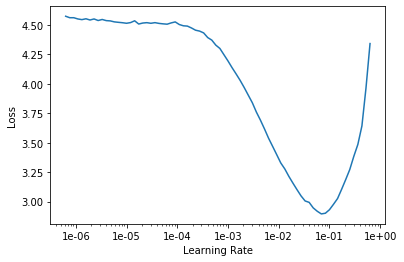

In [119]:
learner.recorder.plot()

In [14]:
data.classes

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [15]:
lr = 0.01

In [129]:
learner.fit_one_cycle(5, slice(lr))

In [130]:
interp = ClassificationInterpretation.from_learner(learner)

In [131]:
interp.most_confused()

[('bicycle', 'person', 5),
 ('chair', 'sofa', 5),
 ('diningtable', 'person', 4),
 ('horse', 'person', 4),
 ('motorbike', 'person', 4),
 ('person', 'dog', 4),
 ('aeroplane', 'car', 3),
 ('car', 'person', 3),
 ('chair', 'diningtable', 3),
 ('chair', 'pottedplant', 3),
 ('person', 'diningtable', 3),
 ('person', 'sofa', 3),
 ('sofa', 'person', 3),
 ('aeroplane', 'boat', 2),
 ('bicycle', 'motorbike', 2),
 ('car', 'train', 2),
 ('cat', 'chair', 2),
 ('cow', 'person', 2),
 ('dog', 'person', 2),
 ('person', 'bird', 2),
 ('person', 'bus', 2),
 ('person', 'car', 2),
 ('person', 'horse', 2),
 ('train', 'bus', 2),
 ('train', 'car', 2),
 ('bicycle', 'bus', 1),
 ('bird', 'diningtable', 1),
 ('bird', 'dog', 1),
 ('bird', 'person', 1),
 ('boat', 'car', 1),
 ('bottle', 'diningtable', 1),
 ('bottle', 'person', 1),
 ('bus', 'boat', 1),
 ('bus', 'car', 1),
 ('bus', 'person', 1),
 ('bus', 'train', 1),
 ('car', 'bus', 1),
 ('cat', 'dog', 1),
 ('chair', 'cat', 1),
 ('chair', 'person', 1),
 ('chair', 'tvmonit

In [16]:
learner.unfreeze()

In [17]:
learner.fit_one_cycle(5, slice(1e-5, lr/5))

In [13]:
learner.save('basic-unfreeze')

NameError: name 'learner' is not defined

In [12]:
learner = cnn_learner(data, arch, accuracy_long)

NameError: name 'arch' is not defined

In [15]:
learner.load('basic-unfreeze')

Learner(data=ImageDataBunch;

Train: LabelList (2001 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
car,horse,person,car,aeroplane
Path: /home/jupyter/.fastai/data/pascal;

Valid: LabelList (500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
person,cat,boat,bus,bus
Path: /home/jupyter/.fastai/data/pascal;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [97]:
learner.predict(data.valid_ds[0][0])

(Category person,
 tensor(14),
 tensor([1.2976e-07, 1.1996e-09, 1.0824e-09, 1.4610e-09, 1.7292e-07, 2.6442e-09,
         1.2658e-09, 6.5280e-10, 4.2606e-06, 3.5121e-08, 2.2675e-05, 1.1843e-08,
         2.3039e-08, 2.9577e-08, 9.9997e-01, 3.3305e-09, 7.6914e-09, 3.9772e-09,
         1.9527e-08, 3.7922e-09]))

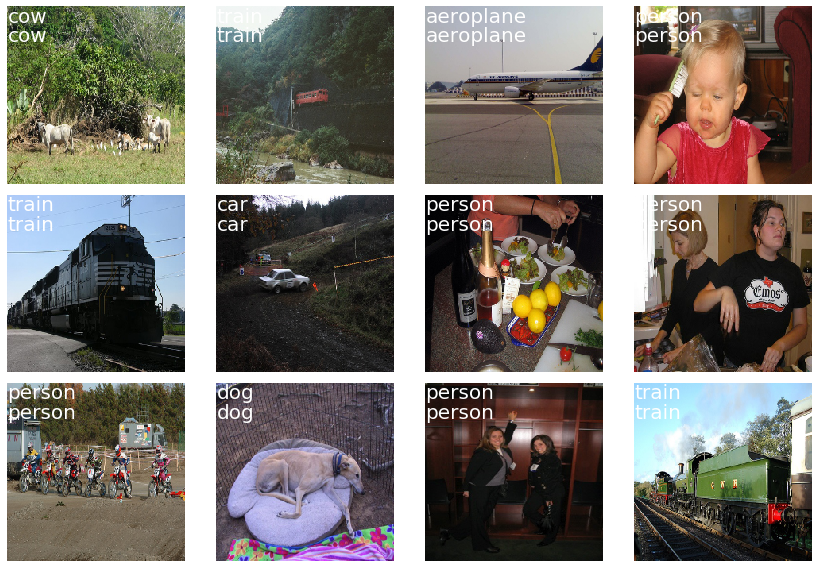

In [14]:
fig, axes = plt.subplots(3, 4, figsize = (12, 8))
for i,ax in enumerate(axes.flat):
    x, y = data.valid_ds[i]
    ax = show_image(x, ax = ax)
    ypred = learner.predict(x)[0]
    text = ax.text(0,0, str(y), color = 'white',
                           verticalalignment = 'top', fontsize = 20)
    text2 = ax.text(0, 25, str(ypred), color = 'white',
                   verticalalignment = 'top', fontsize = 20)
    
plt.tight_layout()

In [16]:
x,y = data.train_ds[1]

In [42]:
a = (0,0)

In [18]:
i = 0

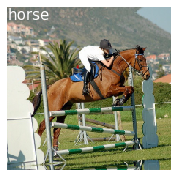

In [90]:
ax = show_image(x)
text = ax.text(0,0, str(y),color = 'white',verticalalignment = 'top', fontsize = 15)

In [13]:
learner.load('basic-unfreeze')

Learner(data=ImageDataBunch;

Train: LabelList (2001 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
car,person,aeroplane,person,dog
Path: /home/jupyter/.fastai/data/pascal;

Valid: LabelList (500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cow,train,aeroplane,person,train
Path: /home/jupyter/.fastai/data/pascal;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64

Bbox only 

In [71]:
BB_CSV = PATH/'tmp/bb.csv'

In [16]:
trn_lrg_anno[0]

NameError: name 'trn_lrg_anno' is not defined

In [32]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])

In [34]:
bbs = [' '.join(str(p) for p in o) for o in bb]

In [1]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns = ['fn', 'bbox'])

NameError: name 'pd' is not defined

In [42]:
df.to_csv(BB_CSV, index = False)

In [72]:
df = pd.read_csv(BB_CSV)

In [73]:
df.head()

fn            bbox
0  000012.jpg  96 155 270 351
1  000017.jpg   77 89 336 403
2  000023.jpg     1 2 462 243
3  000026.jpg  124 89 212 337
4  000032.jpg  77 103 183 375

In [17]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 270 351\n',
 '000017.jpg,77 89 336 403\n',
 '000023.jpg,1 2 462 243\n',
 '000026.jpg,124 89 212 337\n']

In [21]:
df.head()

fn            bbox
0  000012.jpg  96 155 270 351
1  000017.jpg   77 89 336 403
2  000023.jpg     1 2 462 243
3  000026.jpg  124 89 212 337
4  000032.jpg  77 103 183 375

In [25]:
trn_lrg_anno[12]

(array([ 96, 155, 270, 351]), 7)

In [32]:
bb_anno = {o: trn_lrg_anno[o][0] for o in trn_ids}

In [33]:
trn_fns_id = {o[FILE_NAME]: o[ID] for o in trn_j[IMAGES]}

Trying a new approach to make databunch using folder and not csv

In [35]:
def name(filename):
    return str(filename)[-10:]

In [30]:
def get_bb(f):
    bb = list(bb_anno[trn_fns_id[name(f)]])
    lbl = cats[trn_lrg_anno[trn_fns_id[name(f)]][1]]
    return [[bb], [lbl]]

In [76]:
def get_bbpoints(f):
    getbb = get_bb(f)
    y1,x1,y2,x2 = getbb[0][0]
    y1,y2 = float(y1),float(y2)
    return tensor([y1,x1],[y1,x2],[y2,x1],[y2,x2])

In [77]:
def get_bbpoint(f):
    getbb = get_bb(f)
    y1,x1,y2,x2 = getbb[0][0]
    x = (x1+x2)/2.
    y = (y1+y2)/2.
    return tensor([y,x])

In [113]:
get_bb(PATH/JPEGS/str(df.fn[5]))

[[[106, 8, 263, 499]], ['aeroplane']]

In [82]:
fname = PATH/JPEGS/str(df.fn[5])

In [83]:
fname.name

'000033.jpg'

In [85]:
for o in trn_j[IMAGES]:
    if o[FILE_NAME] == '008138.jpg':
        print(o[ID])

Realized here that the issue is with the json file,
It does not contain information for some of the images in the folder

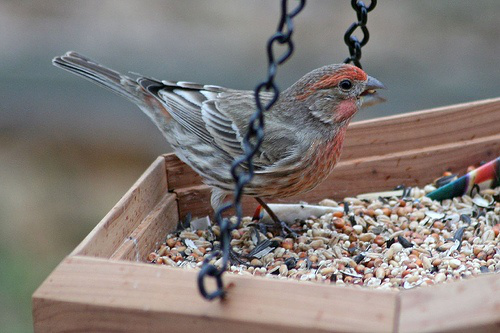

In [86]:
open_image(PATH/JPEGS/'008138.jpg')

In [233]:
src = (ObjectItemList.from_csv(PATH, 'tmp/bb.csv', folder = JPEGS)
      .split_by_rand_pct(0.2)
      .label_from_func(get_bb)
      .transform(get_transforms(), resize_method = ResizeMethod.SQUISH, tfm_y = True ,size = 224)
      .databunch(bs = 16, collate_fn = bb_pad_collate))

In [234]:
x,y = src.dataset[0]

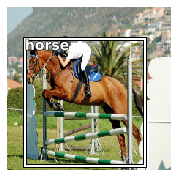

In [235]:
x.show(y=y)

In [89]:
type(y)

fastai.vision.image.ImageBBox

In [90]:
img = open_image(PATH/JPEGS/trn_fns[12])
bbox = ImageBBox.create(*img.size, [[96, 155, 270, 351]])

In [91]:
pnts = get_bbpoint(PATH/JPEGS/trn_fns[12])

In [92]:
pnts

tensor([183., 253.])

In [165]:
270+96/2

318.0

In [93]:
impnts = ImagePoints(FlowField(img.size, pnts))

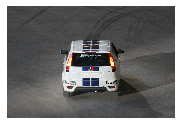

In [94]:
img.show(y=impnts)

In [94]:
y = impnts.data

In [95]:
y

tensor([[-0.4234, -0.3800],
        [ 0.6216,  0.4040]])

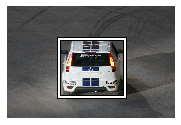

In [95]:
img.show(y=bbox)

We just need to find a way to go from image points to bounding boxes, and if we're successful, we can find the solution to the bounding box only problem by just using MSE

But first, I'll need a function that gives me a tensor of bounding points

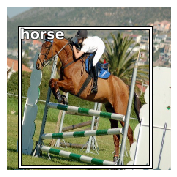

In [96]:
x.show(y = y)

More testing below

In [141]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [142]:
coco

PosixPath('/home/jupyter/.fastai/data/coco_tiny')

In [153]:
lbl_bbox[0]

[[[86.34, 32.52, 95.75, 41.050000000000004],
  [110.52, 98.12, 114.59, 100.07000000000001],
  [51.62, 91.28, 57.339999999999996, 95.23],
  [110.82, 110.48, 126.03999999999999, 125.03],
  [50.18, 96.63, 63.64, 115.3],
  [111.73, 0.69, 124.79, 12.49]],
 ['chair', 'vase', 'vase', 'chair', 'chair', 'chair']]

In [178]:
get_bb(PATH/JPEGS/str(df.fn[5]))

[[[106, 8, 263, 499]], ['aeroplane']]

Now that I have my databunch, I need to start with the learning

In [56]:
type(src)

fastai.vision.data.ImageDataBunch

In [62]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 4))

In [68]:
objectlearn = cnn_learner(src, models.resnet34)


In [75]:
objectlearn.loss_func = MSELossFlat()

Now proceeding the way of bb head pose

In [97]:
data = (PointsItemList.from_csv(PATH,'tmp/bb.csv', folder = JPEGS)
        .split_by_rand_pct(0.2)
        .label_from_func(get_bbpoints)
        .transform(resize_method = ResizeMethod.SQUISH, tfm_y=True, size=600)
        .databunch(bs = 16).normalize(imagenet_stats)
       )

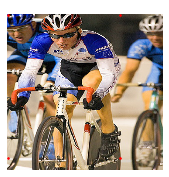

In [107]:
x,y = data.dataset[0]
x.show(y=y)

TypeError: 'ImagePoints' object is not subscriptable

In [215]:
learn = cnn_learner(data, models.resnet34)

In [246]:
learn.loss_func = MSELossFlat(); learn.loss_func

FlattenedLoss of MSELoss()

In [236]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [247]:
torch.cuda.empty_cache()

In [248]:
gc.collect()

9087

In [249]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


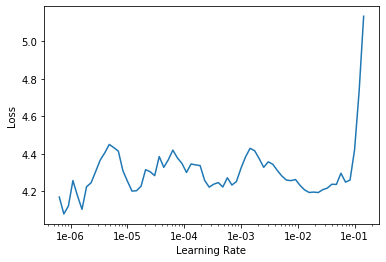

In [240]:
learn.recorder.plot()

In [250]:
lr = 1e-2

In [251]:
learn.fit_one_cycle(5, slice(lr))

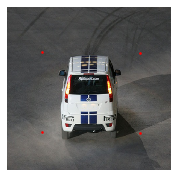

In [252]:
x.show(y = learn.predict(x)[0])

In [254]:
learn.save('stage-1')

In [216]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (2001 items)
x: PointsItemList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: PointsLabelList
ImagePoints (600, 600),ImagePoints (600, 600),ImagePoints (600, 600),ImagePoints (600, 600),ImagePoints (600, 600)
Path: /home/jupyter/.fastai/data/pascal;

Valid: LabelList (500 items)
x: PointsItemList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: PointsLabelList
ImagePoints (600, 600),ImagePoints (600, 600),ImagePoints (600, 600),ImagePoints (600, 600),ImagePoints (600, 600)
Path: /home/jupyter/.fastai/data/pascal;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil

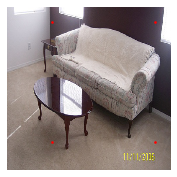

In [220]:
x, y = data.valid_ds[0]
x.show(y = y)

In [221]:
ypred = learn.predict(x)

In [224]:
ypred

(ImagePoints (600, 600), tensor([[-0.4748, -0.7600],
         [-0.4704,  0.5399],
         [ 0.7317, -0.7549],
         [ 0.7324,  0.5376]]), tensor([-0.4748, -0.7600, -0.4704,  0.5399,  0.7317, -0.7549,  0.7324,  0.5376]))

In [231]:
custom_head = nn.Sequential(Flatten(), nn.Linear(25088, 25))

In [236]:
learner = cnn_learner(src, models.resnet34)

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
def detn_loss(input, target, c_t):
    bb_t = target
    bb_i, c_i = input[:,None, :4], input[:, 4:]
    bb_i = torch.sigmoid(bb_i)*224
    bb_t = torch.sigmoid(bb_t)*224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t.flatten())*20
    

In [228]:
learner.loss_func = detn_loss

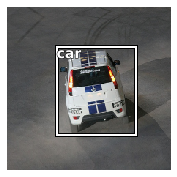

In [229]:
x, y = src.train_ds[0]
x.show(y=y)

In [230]:
learner.lr_find()

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/generic/serialization.cpp:23

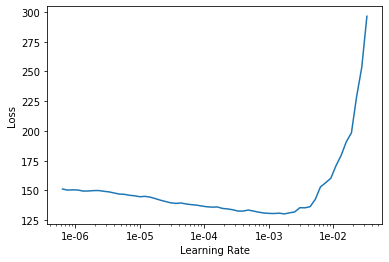

In [43]:
learner.recorder.plot()

In [44]:
lr = 1e-4

In [51]:
learner.fit_one_cycle(3, slice(lr))

In [52]:
learner.unfreeze()

In [53]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


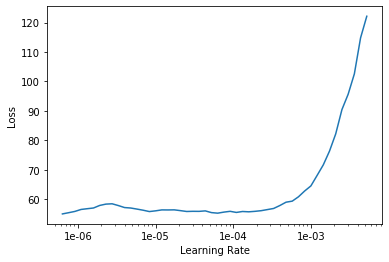

In [54]:
learner.recorder.plot()

In [55]:
learner.fit_one_cycle(3, slice(1e-5,lr/5))

In [56]:
learner.save('bb&classify')

In [232]:
x, y = next(iter(src.train_dl))

tensor([[[[6.9677e-01, 6.9339e-01, 6.9325e-01,  ..., 4.9142e-01,
           4.8024e-01, 4.8794e-01],
          [6.9677e-01, 6.9324e-01, 6.9237e-01,  ..., 4.9063e-01,
           4.7444e-01, 4.8719e-01],
          [6.9764e-01, 6.9149e-01, 6.9412e-01,  ..., 4.9396e-01,
           4.7633e-01, 4.8451e-01],
          ...,
          [2.5266e-01, 2.5221e-01, 2.4050e-01,  ..., 2.6514e-01,
           2.5485e-01, 2.6103e-01],
          [2.3112e-01, 2.3718e-01, 2.3713e-01,  ..., 2.9465e-01,
           2.6560e-01, 2.8567e-01],
          [2.2886e-01, 2.3630e-01, 2.3514e-01,  ..., 2.6612e-01,
           2.6014e-01, 2.6735e-01]],

         [[6.9677e-01, 6.9339e-01, 6.9096e-01,  ..., 5.5960e-01,
           5.5970e-01, 5.5302e-01],
          [6.9677e-01, 6.9324e-01, 6.9237e-01,  ..., 5.5885e-01,
           5.5528e-01, 5.5158e-01],
          [6.9764e-01, 6.9149e-01, 6.9412e-01,  ..., 5.5811e-01,
           5.6411e-01, 5.5706e-01],
          ...,
          [1.9096e-01, 1.9129e-01, 1.7994e-01,  ..., 3.6728

In [329]:
type(x), type(xb)

(fastai.vision.image.Image, torch.Tensor)

In [332]:
xb, _ = src.one_item(x)

In [239]:
xb

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/THC/THCCachingHostAllocator.cpp:296

In [331]:
xb_im = Image(xb[0])

In [317]:
xb

fastai.vision.image.Image

In [268]:
pred = learner.model(x)

In [269]:
pred[0].shape

torch.Size([25])

In [333]:
x,_ = src.train_ds[0]

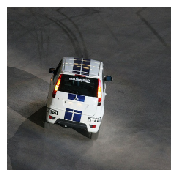

In [334]:
x.show()

In [335]:
xb,_ = src.one_item(x)

In [336]:
xb_im = Image(xb[0])

Realized above that src was never normalized at the first place!

In [338]:
x, y = next(iter(src.train_dl))

In [341]:
x_im = Image(x[0])

list

Restarting again with the help of lesson 6 

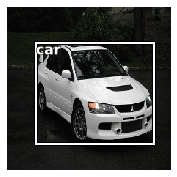

In [198]:
x,y = src.valid_ds[10]; x.show(y=y)

In [199]:
src.train_ds.y[0]

ImageBBox (333, 500)

In [200]:
m = learner.model.eval();

In [201]:
xb,_ = src.one_item(x)
xb = xb.cuda()

In [202]:
pred = learner.model(xb)


In [203]:
ans = torch.argmax(pred[:,4:])

In [204]:
a = pred[:,4:]

In [205]:
a

tensor([[-10.8571,  -8.8506,  -8.1163,  -7.5708,  -3.7434,  -7.0607,  -2.8868,
           6.1384,  -8.2295,  -4.2836,  -9.4334,  -6.2482,  -6.0044,  -9.7728,
          -5.5503,  -6.2271, -12.5904,  -7.2960,  -9.4533,  -9.6394, -10.7820]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [206]:
ans

tensor(7, device='cuda:0')

In [188]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [207]:
predbb = pred[0,None,:4]; predbb.shape

torch.Size([1, 4])

In [208]:
predbb

tensor([[-1.1659, -1.8934,  0.5518,  3.9186]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [211]:
predbba = np.array(predbb) ; predbba

array([[-1.165907, -1.893411,  0.551763,  3.918609]], dtype=float32)

In [217]:
int(ans)

7

In [212]:
predbbascale = (predbba*112) + 112

In [218]:
box = ImageBBox.create(224,224, predbbascale, labels = [0], classes = [cats[int(ans)]])

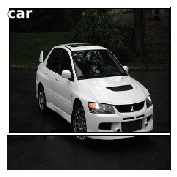

In [219]:
x.show(y=box)

In [238]:
src.classes

['background',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']